In [1]:
!pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_SIZE = 128
DATA_DIR = '/Users/bhaau/Downloads/plantvillage dataset/color'  # Adjust to your dataset path
CATEGORIES = os.listdir(DATA_DIR)  # Get categories from dataset folder

def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        
        # Skip any non-directory files like .DS_Store
        if not os.path.isdir(path):
            continue
        
        class_num = CATEGORIES.index(category)
        
        for img in os.listdir(path):
            if img.endswith(".jpg") or img.endswith(".png"):  # Only process image files
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_array, class_num])
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
                    pass
    return data

# Load data
data = load_data()

# Shuffle the data
np.random.shuffle(data)

# Separate features (images) and labels
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# Normalize the pixel values (0-255) to (0-1)
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(y, num_classes=len(CATEGORIES))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape: {X_test.shape}")


Training Data Shape: (1200, 128, 128, 3)
Test Data Shape: (301, 128, 128, 3)


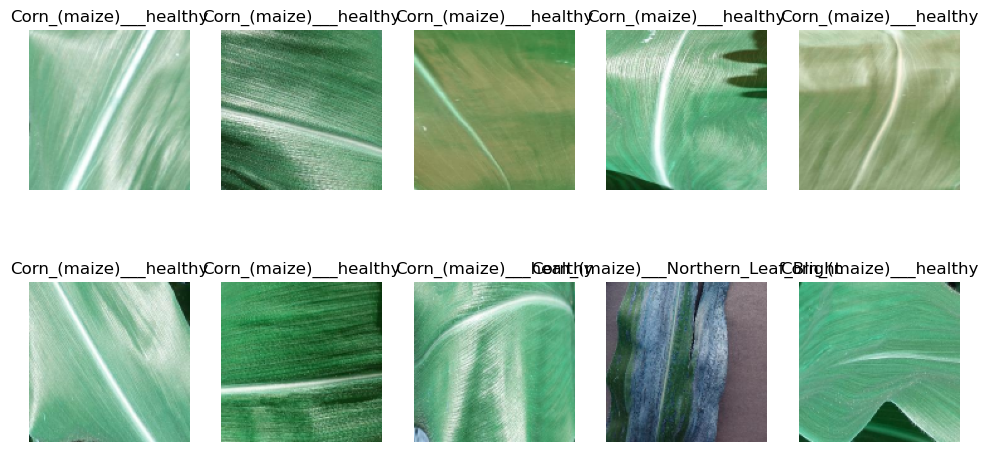

In [4]:
import matplotlib.pyplot as plt

def plot_sample_images(data, categories):
    fig, ax = plt.subplots(2, 5, figsize=(12, 6))
    ax = ax.ravel()
    for i in np.arange(0, 10):
        ax[i].imshow(data[i][0])
        ax[i].set_title(categories[data[i][1]])
        ax[i].axis('off')
        
plot_sample_images(data, CATEGORIES)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit on training data
datagen.fit(X_train)


In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create the model
model = Sequential()

# Add Input layer
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,671 (12.63 MB)

 Trainable params: 3,309,671 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_test, y_test))


Epoch 1/20


/Users/bhaau/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.7099 - loss: 1.2452 - val_accuracy: 0.8505 - val_loss: 0.3961
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8798 - loss: 0.4709 - val_accuracy: 0.9136 - val_loss: 0.3480
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8961 - loss: 0.3251 - val_accuracy: 0.8472 - val_loss: 1.2106
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.8835 - loss: 0.5572 - val_accuracy: 0.8937 - val_loss: 0.2356
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9269 - loss: 0.2348 - val_accuracy: 0.9203 - val_loss: 0.1924
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.9317 - loss: 0.2678 - val_accuracy: 0.9136 - val_loss: 0.1729
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.9323 - loss: 0.2061 - val_accuracy: 0.9136 - val_loss: 0.2142
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.9338 - loss: 0.1758 - val_accuracy: 0.9203 - val_

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9416 - loss: 0.2007
Test Accuracy: 94.02%


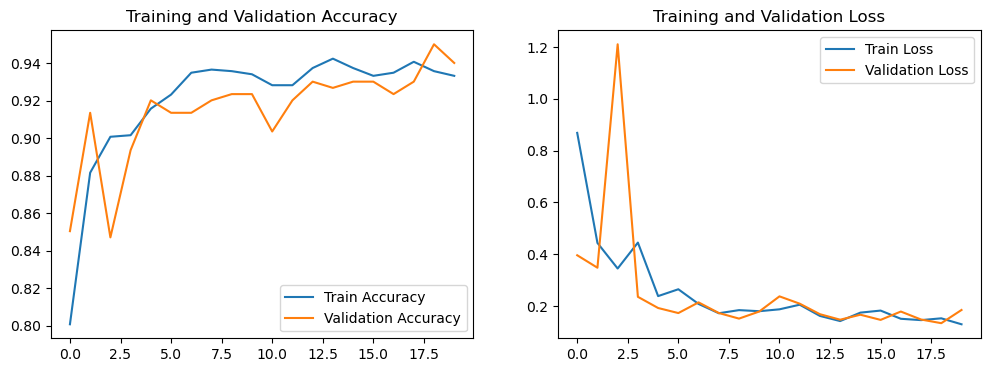

In [10]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [11]:
model.save("plant_disease_model.h5")
